### 1) Clarify business objectives (first 10 minutes)

Pick 3–5 measurable questions to drive analysis. Examples:

What is monthly GMV (gross merchandise value), net revenue, and trend by product/category/region?

Which SKUs drive margin and which cause returns/cancellations?

What’s the cancellation & return rate, and why (product, seller, shipping)?

Which customers are high-value (RFM / CLTV) and how to increase retention?

How effective are promotions (lift, ROI)?


### 2) Ingest & version (design the pipeline)

Landing zone: raw CSV/Parquet in object storage (S3 / GCS).

Raw → Staging → Curated (apply transformations in dbt/Airflow).

Maintain schema, ingestion timestamp, file hash/version.

Store curated facts in a warehouse (BigQuery / Snowflake / Postgres for small scale).

In [34]:
import pandas as pd

df = pd.read_csv("Amazon Sale Report.csv")

# Convert column names to snake_case
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r'[^a-zA-Z0-9]+', '_', regex=True)
              .str.replace(r'(^_+|_+$)', '', regex=True)
)

print(df.head())   # shows first 5 rows
print(df.shape)    # shows (rows, columns)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\2956315249.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Amazon Sale Report.csv")


   index             order_id      date                        status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  fulfilment sales_channel ship_service_level    style              sku  \
0   Merchant     Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant     Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon     Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant     Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon     Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        category  ... currency  amount    ship_city   ship_state  \
0            Set  ...      INR  647.62    

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [27]:
# Data Cleaning rules:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce',infer_datetime_format=True)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\96766810.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce',infer_datetime_format=True)
C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\96766810.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce',infer_datetime_format=True)


### 2. errors='coerce'

If Pandas cannot parse a date (e.g., "Not Available", "32-13-2025", or blank cells), instead of throwing an error, it will replace it with NaT (Not a Time).

This makes the dataset cleaner because bad or missing dates don’t crash your code.

### 3. infer_datetime_format=True

Pandas tries to guess the date format automatically (like MM-DD-YY or DD-MM-YYYY) to speed up parsing.

Useful when dates have a consistent format. It reduces parsing time for large datasets.

But: if your dataset has multiple messy formats, sometimes you should specify format= instead.

In [28]:
# Data Cleaning rules:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce',infer_datetime_format=True)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\96766810.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce',infer_datetime_format=True)


In [29]:
## Normalizing the text fields
df['Status'] = df['Status'].str.strip().str.title()

In [30]:
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered To Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [35]:
df.head()

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed_22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [36]:
df.shape

(128975, 24)

In [37]:
# Data Cleaning process
print(df.isnull().sum())

index                     0
order_id                  0
date                      0
status                    0
fulfilment                0
sales_channel             0
ship_service_level        0
style                     0
sku                       0
category                  0
size                      0
asin                      0
courier_status         6872
qty                       0
currency               7795
amount                 7795
ship_city                33
ship_state               33
ship_postal_code         33
ship_country             33
promotion_ids         49153
b2b                       0
fulfilled_by          89698
unnamed_22            49050
dtype: int64


In [39]:
df = df.drop_duplicates()
df.head()

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed_22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [40]:
print(df.duplicated().sum())

0


In [41]:
# Converting the Date format formally
df['date'] = pd.to_datetime(df['date'])
df.info()

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\3129714057.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               128975 non-null  int64         
 1   order_id            128975 non-null  object        
 2   date                128975 non-null  datetime64[ns]
 3   status              128975 non-null  object        
 4   fulfilment          128975 non-null  object        
 5   sales_channel       128975 non-null  object        
 6   ship_service_level  128975 non-null  object        
 7   style               128975 non-null  object        
 8   sku                 128975 non-null  object        
 9   category            128975 non-null  object        
 10  size                128975 non-null  object        
 11  asin                128975 non-null  object        
 12  courier_status      122103 non-null  object        
 13  qty                 128975 no

In [44]:
df.isnull().sum()


index                     0
order_id                  0
date                      0
status                    0
fulfilment                0
sales_channel             0
ship_service_level        0
style                     0
sku                       0
category                  0
size                      0
asin                      0
courier_status         6872
qty                       0
currency               7795
amount                 7795
ship_city                33
ship_state               33
ship_postal_code         33
ship_country             33
promotion_ids         49153
b2b                       0
fulfilled_by          89698
unnamed_22            49050
dtype: int64

In [45]:
df.head()

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed_22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [46]:
df.dropna()

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed_22
49051,49051,408-4858463-2356347,2022-05-31,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0385,J0385-KR-M,kurta,...,INR,888.0,RAJAHMUNDRY,ANDHRA PRADESH,533126.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
49077,49077,402-7697834-2682766,2022-05-31,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3654,JNE3654-TP-XXL,Top,...,INR,371.0,CHENNAI,TAMIL NADU,600042.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
49081,49081,402-7031777-0396341,2022-05-31,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3798,JNE3798-KR-XS,Western Dress,...,INR,771.0,NEDUMANGAD,KERALA,695541.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
49082,49082,408-1235521-4337163,2022-05-31,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0152,J0152-DR-L,Western Dress,...,INR,0.0,LEH,JAMMU & KASHMIR,194101.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
49083,49083,403-3845187-4421165,2022-05-31,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0157,J0157-DR-XL,Western Dress,...,INR,690.0,PIMPRI CHINCHWAD,MAHARASHTRA,411027.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128872,128872,405-4724097-1016369,2022-06-01,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0243,J0243-DR-S,Ethnic Dress,...,INR,999.0,ALLUR,ANDHRA PRADESH,524315.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
128873,128873,405-4724097-1016369,2022-06-01,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0079,J0079-SKD-S,Set,...,INR,1523.0,ALLUR,ANDHRA PRADESH,524315.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
128874,128874,405-4724097-1016369,2022-06-01,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0009,J0009-SKD-S,Set,...,INR,854.0,ALLUR,ANDHRA PRADESH,524315.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False
128887,128887,405-6493630-8542756,2022-05-31,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,J0301,J0301-TP-M,Top,...,INR,518.0,NOIDA,UTTAR PRADESH,201301.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,False


In [47]:
df.isnull().sum()

index                     0
order_id                  0
date                      0
status                    0
fulfilment                0
sales_channel             0
ship_service_level        0
style                     0
sku                       0
category                  0
size                      0
asin                      0
courier_status         6872
qty                       0
currency               7795
amount                 7795
ship_city                33
ship_state               33
ship_postal_code         33
ship_country             33
promotion_ids         49153
b2b                       0
fulfilled_by          89698
unnamed_22            49050
dtype: int64

In [57]:
## Columns with too many missing values --> Just drop
df = df.drop(columns=['promotion_ids','b2b'])

In [50]:
## Columns with few missing values -> fill them with something simple
df['ship_city'].fillna('Unknown',inplace=True)
df['ship_state'].fillna('Unknown',inplace=True)
df['ship_postal_code'].fillna('Unknown',inplace=True)
df['ship_country'].fillna('Unknown',inplace=True)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\2734652697.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ship_city'].fillna('Unknown',inplace=True)
C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\2734652697.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [58]:
df['amount'].fillna(df['amount'].median(),inplace=True)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\2875013084.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['amount'].fillna(df['amount'].median(),inplace=True)


In [59]:
## Categorical columns(text) with missing values-> fill with most common value
## (mode)
df['courier_status'].fillna('Missing',inplace=True)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\1590086082.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['courier_status'].fillna('Missing',inplace=True)


In [60]:
df.isnull().sum()

index                    0
order_id                 0
date                     0
status                   0
fulfilment               0
sales_channel            0
ship_service_level       0
style                    0
sku                      0
category                 0
size                     0
asin                     0
courier_status           0
qty                      0
currency              7795
amount                   0
ship_city                0
ship_state               0
ship_postal_code         0
ship_country             0
dtype: int64

In [62]:
df['currency'].fillna('INR',inplace=True)

C:\Users\Jayasurya R N\AppData\Local\Temp\ipykernel_23760\2210565283.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['currency'].fillna('INR',inplace=True)


In [63]:
df.isnull().sum()

index                 0
order_id              0
date                  0
status                0
fulfilment            0
sales_channel         0
ship_service_level    0
style                 0
sku                   0
category              0
size                  0
asin                  0
courier_status        0
qty                   0
currency              0
amount                0
ship_city             0
ship_state            0
ship_postal_code      0
ship_country          0
dtype: int64

In [64]:
# Step 1: Basic info about the dataset

# Shape of dataset
df.shape

(128975, 20)

In [65]:
# data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               128975 non-null  int64         
 1   order_id            128975 non-null  object        
 2   date                128975 non-null  datetime64[ns]
 3   status              128975 non-null  object        
 4   fulfilment          128975 non-null  object        
 5   sales_channel       128975 non-null  object        
 6   ship_service_level  128975 non-null  object        
 7   style               128975 non-null  object        
 8   sku                 128975 non-null  object        
 9   category            128975 non-null  object        
 10  size                128975 non-null  object        
 11  asin                128975 non-null  object        
 12  courier_status      128975 non-null  object        
 13  qty                 128975 no

In [66]:
# Quick stats (only numeric columns)
df.describe()

,index,date,qty,amount
count,128975.000000,128975,128975.000000,128975.000000
mean,64487.000000,2022-05-12 11:49:27.951928576,0.904431,645.928694
min,0.000000,2022-03-31 00:00:00,0.000000,0.000000
25%,32243.500000,2022-04-20 00:00:00,1.000000,459.000000
50%,64487.000000,2022-05-10 00:00:00,1.000000,605.000000
75%,96730.500000,2022-06-04 00:00:00,1.000000,771.000000
max,128974.000000,2022-06-29 00:00:00,15.000000,5584.000000
std,37232.019822,NaN,0.313354,272.778829


In [ ]:
# Step 2: Understand categorical columns
# Count unqiue values in important categories
df['status'].value_count()
df['sales_channel'].value_counts()
df['category'].value_counts()
df['courier_status'].value_counts()

In [68]:
df.head()

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,size,asin,courier_status,qty,currency,amount,ship_city,ship_state,ship_postal_code,ship_country
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,Missing,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,Missing,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN


In [70]:
# Checking the numeric values
df['amount'].describe()

count    128975.000000
mean        645.928694
std         272.778829
min           0.000000
25%         459.000000
50%         605.000000
75%         771.000000
max        5584.000000
Name: amount, dtype: float64

In [73]:
## Time based Analysis
df['date'] = pd.to_datetime(df['date'])

## Sales trend over time
sales_by_date = df.groupby('date')['amount'].sum().reset_index()
sales_by_date.sort_values(by='amount',ascending=False).head(5)

,date,amount
34,2022-05-04,1298904.17
33,2022-05-03,1289892.59
32,2022-05-02,1261262.06
14,2022-04-14,1181247.56
20,2022-04-20,1150611.41


In [78]:
# Extract month number (1-12)
df['month'] = df['date'].dt.month
# Extract month name
df['month_name'] = df['date'].dt.month_name()
# Extract day of the month (1-31)
df['day'] = df['date'].dt.day
print(df)

         index             order_id       date                        status  \
0            0  405-8078784-5731545 2022-04-30                     Cancelled   
1            1  171-9198151-1101146 2022-04-30  Shipped - Delivered to Buyer   
2            2  404-0687676-7273146 2022-04-30                       Shipped   
3            3  403-9615377-8133951 2022-04-30                     Cancelled   
4            4  407-1069790-7240320 2022-04-30                       Shipped   
...        ...                  ...        ...                           ...   
128970  128970  406-6001380-7673107 2022-05-31                       Shipped   
128971  128971  402-9551604-7544318 2022-05-31                       Shipped   
128972  128972  407-9547469-3152358 2022-05-31                       Shipped   
128973  128973  402-6184140-0545956 2022-05-31                       Shipped   
128974  128974  408-7436540-8728312 2022-05-31                       Shipped   

       fulfilment sales_channel ship_se

In [79]:
df.head()

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,qty,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,month,month_name,day
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,4,April,30
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,4,April,30
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,4,April,30
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,4,April,30
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,4,April,30


In [87]:
sales_by_month = df.groupby('month')['amount'].sum().reset_index()
sales_by_month.sort_values(by='amount',ascending=False).head(5)

## April-May-June as been generated the most of the amount.

,month,amount
1,4,30653103.32
2,5,27741396.75
3,6,24807024.38
0,3,107128.85


In [93]:
# Daily Sales Analysis.
sales_by_day = df.groupby('day')['amount'].sum().reset_index()
sales_by_day.sort_values(by='amount',ascending=False)

,day,amount
1,2,3180541.41
3,4,3171449.44
2,3,3147536.16
0,1,3066601.33
7,8,3062922.76
4,5,3004346.25
6,7,2946870.37
13,14,2939403.47
14,15,2911187.12
8,9,2895270.46


In [95]:
category_wise = df.groupby('category')['amount'].sum().reset_index()
category_wise.sort_values(by='amount', ascending=False)

,category,amount
5,Set,41165534.03
8,kurta,23211346.70
7,Western Dress,11697652.69
6,Top,5624277.30
3,Ethnic Dress,831147.66
0,Blouse,485633.18
1,Bottom,162767.98
4,Saree,129378.76
2,Dupatta,915.00


# Insights
Set(41165534),kurta(23211346),western dress(11697652),top(5624277) are generated the most revenue

In [97]:
# Revenbyu by sales_channels
Revenue_by_channel = df.groupby('sales_channel')['amount'].sum().sort_values(ascending=False)
Revenue_by_channel

sales_channel
Amazon.in     83233633.3
Non-Amazon       75020.0
Name: amount, dtype: float64

In [ ]:
## Business Insights:
# 1) 50% of the revenue generated by set,kurta,western dress and top.
# 2) 80% of the revenue generated by Amazon.in sales channels
# Trend Analysis:
# 40% of the revenue generated in April,May and June.


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  128975 non-null  int64         
 1   order_id               128975 non-null  object        
 2   date                   128975 non-null  datetime64[ns]
 3   status                 128975 non-null  object        
 4   fulfilment             128975 non-null  object        
 5   sales_channel          128975 non-null  object        
 6   ship_service_level     128975 non-null  object        
 7   style                  128975 non-null  object        
 8   sku                    128975 non-null  object        
 9   category               128975 non-null  object        
 10  size                   128975 non-null  object        
 11  asin                   128975 non-null  object        
 12  courier_status         128975 non-null  obje

In [122]:
cleaned_dataset = df.to_csv("Clean_amazon_sales.csv",index=False)
print(cleaned_dataset)

None


In [104]:
## Freelancing client project Analysis.
df.shape

(128975, 24)

In [105]:
df.columns

Index(['index', 'order_id', 'date', 'status', 'fulfilment', 'sales_channel',
       'ship_service_level', 'style', 'sku', 'category', 'size', 'asin',
       'courier_status', 'qty', 'currency', 'amount', 'ship_city',
       'ship_state', 'ship_postal_code', 'ship_country', 'month', 'month_name',
       'day', 'monthly_sale_Analysis'],
      dtype='object')

In [109]:
df.head()


,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,month,month_name,day,monthly_sale_Analysis
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,4,April,30,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,4,April,30,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,4,April,30,NaN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,4,April,30,107128.85
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,4,April,30,30653103.32


<Axes: title={'center': 'Order Status Disturbution'}, xlabel='status'>

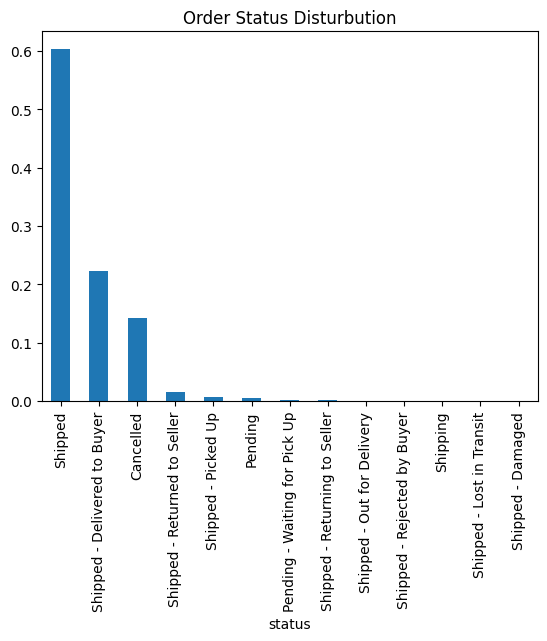

In [107]:
## Step 2: Univariate Analysis
# Order Status
df['status'].value_counts(normalize=True).plot(kind='bar',title="Order Status Disturbution")

In [ ]:
# 80% Deliveries are delivered and 20% are not delivered.

### Sales Channels

<Axes: title={'center': 'Sales by Channels'}, xlabel='sales_channel'>

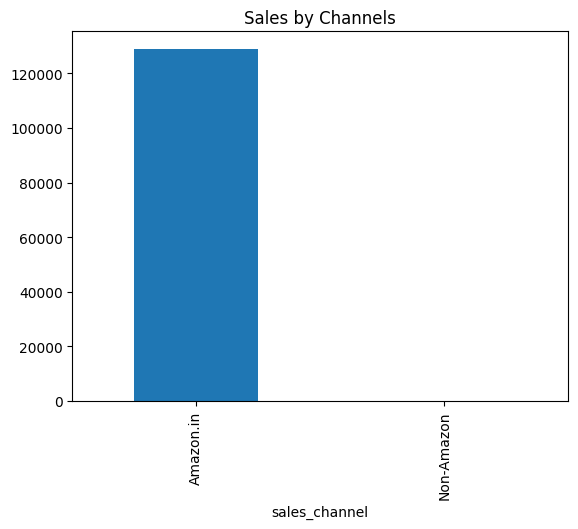

In [110]:
df['sales_channel'].value_counts().plot(kind='bar', title="Sales by Channels")

In [ ]:
### 95% of sales done in Amazon.in

### Categories

<Axes: title={'center': 'Top 10 Categories by Orders'}, xlabel='category'>

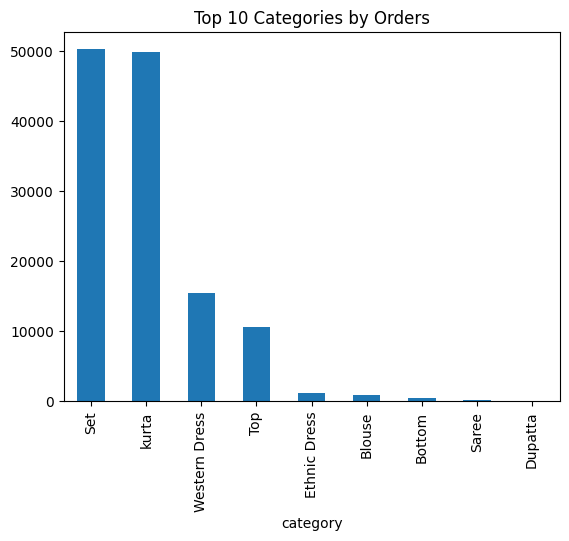

In [111]:
df['category'].value_counts().head(10).plot(kind="bar",title="Top 10 Categories by Orders")

### 80% of the Sales done by set,kurta,Western Dress and Top.

# Amount and Qty

Text(0.5, 1.0, 'Outlier Check: Amount')

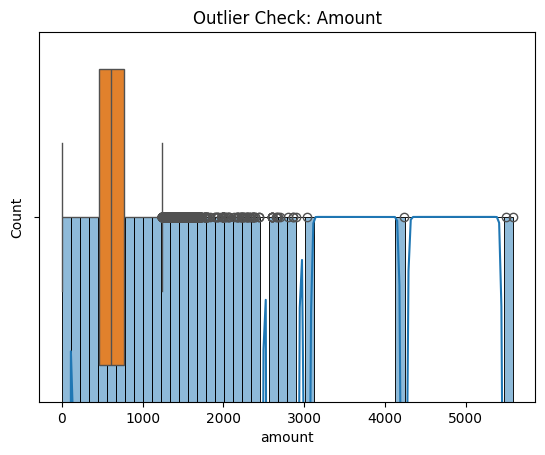

In [113]:
import seaborn as sns
sns.histplot(df['amount'],bins=50,kde=True).set_title("Order Amount Distribution")
sns.boxplot(x=df['amount']).set_title("Outlier Check: Amount")

### Step 3: Bivariate Analysis(Relationship betweeen columns)

<Axes: title={'center': 'Daily Sales Trend'}, xlabel='date'>

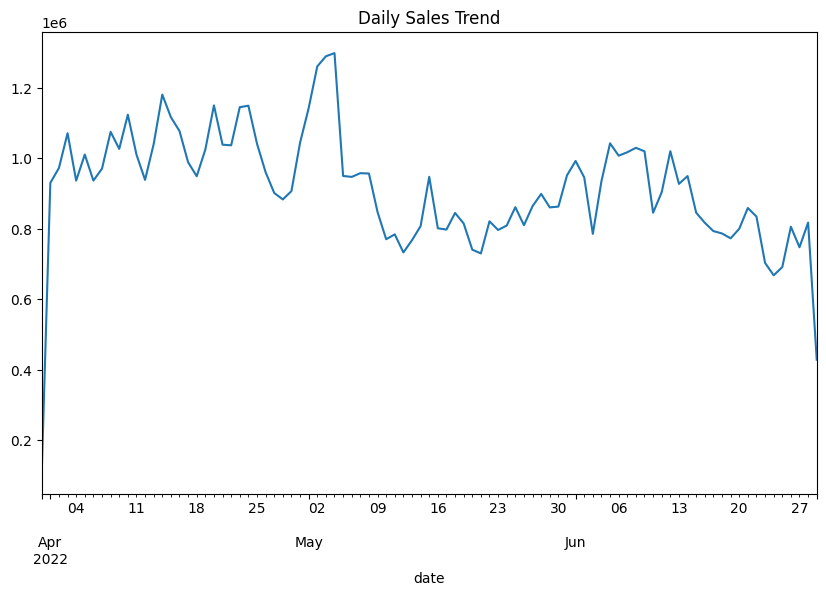

In [117]:
sales_trend = df.groupby('date')['amount'].sum()
sales_trend.plot(figsize=(10,6),title="Daily Sales Trend")

### Revenue by Category

<Axes: title={'center': 'Revenue by Category'}, xlabel='category'>

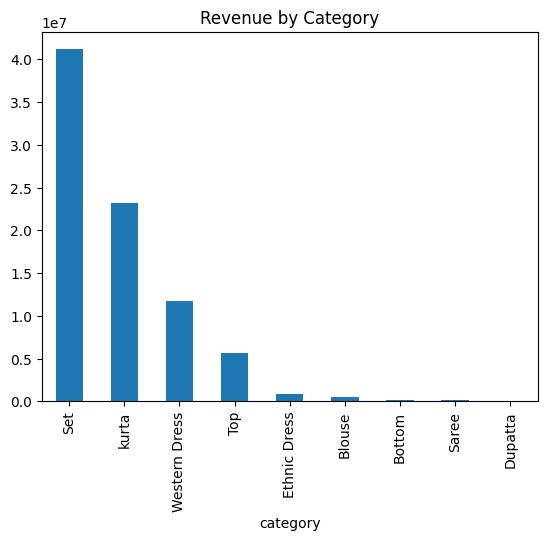

In [119]:
df.groupby('category')['amount'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Revenue by Category')

<Axes: title={'center': 'Courier Status Disturbution'}, xlabel='courier_status'>

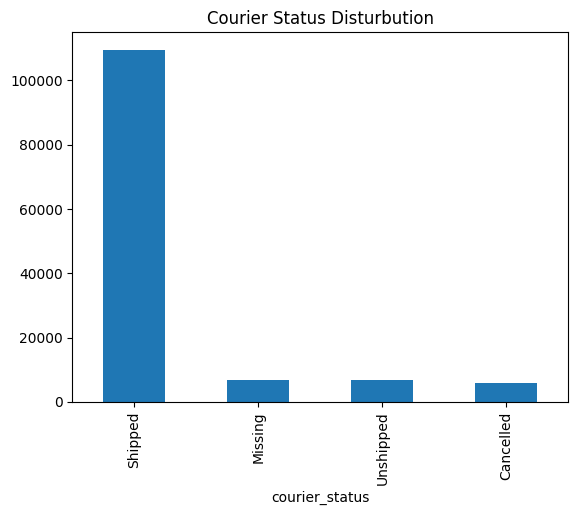

In [120]:
### Courier Performance
df['courier_status'].value_counts().plot(kind="bar", title="Courier Status Disturbution")

### 80% of Deliveries are delivered

### 1. Category Mix

Insight: 50% of revenue from just 4 categories (Set, Kurta, Western Dress, Top).

Implication: Portfolio is concentrated — risk if demand shifts.

Recommendation: Diversify into underperforming categories (e.g., kidswear, accessories) or double down on top 4 with more SKUs.

### 2. Channel Dependency

Insight: 80% of revenue is from Amazon.in.

Implication: Over-reliance on single channel → risk from platform policy changes.

Recommendation: Explore Myntra, Flipkart, Ajio, and direct-to-consumer (D2C) website.

### 3. Seasonality

Insight: 40% of revenue is generated in Apr–Jun.

Implication: High seasonality → cash flow imbalance, stockouts risk.

Recommendation: Pre-stock inventory before Q2, launch promotions in off-season.

In [127]:
# Connecting to postgres SQL
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import set_with_dataframe

def upload_csv_to_postgres(csv_file,table_name,db_name,user,password,host="localhost",port=5432):
    """
    Uploads a csv file into postgresSQL table.

    parameters:
    --------------
    csv_file :str
        Python_automation/SQL+ python_Automation projects/Clean_amazon_sales.csv
    table_name : str
        "amazon_sales"
    db_name : str
        "Amazon_Sales_DB"
    user : str
        "postgres"
    password : str
         "Postgr@0909"
    """
    try:
        # 1. Load CSV into DataFrame
        df = pd.read_csv(csv_file)
        print(f"✅ Loaded {len(df)} rows from {csv_file}")

         # Use psycopg2 parameters (no URL confusion with @)
        engine = create_engine(
            f"postgresql+psycopg2://{user}:{password.replace('@', '%40')}@{host}:{port}/{db_name}"
        )

        # 3. Upload DataFrame to PostgreSQL
        df.to_sql(table_name, engine, if_exists="replace", index=False)
        print(f"🚀 Successfully uploaded {len(df)} rows into PostgreSQL table: {table_name}")

    except Exception as e:
        print(f"❌ Error: {e}")

      # 3. Upload DataFrame to PostgreSQL
        df.to_sql(table_name, engine, if_exists="replace", index=False)
        print(f"🚀 Successfully uploaded to PostgreSQL table: {table_name}")

    except Exception as e:
        print(f"❌ Error: {e}")


def run_query(query):
    """
    Runs a SQL query and returns the results as a pandas DataFrame.
    """
    try:
        conn = psycopg2.connect(
             dbname="Amazon_sales_DB",   # Change this to your database name
             user="postgres",   # Your PostgreSQL username
             password="Postgr@0909",  # Your PostgreSQL password
             host="localhost",       # or IP if it's remote
             port="5432" 
        )
        cur = conn.cursor()
        cur.execute(query)
        data = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data,columns=columns)
        cur.close()
        conn.close()
        return df

    except Exception as e:
        print(f" Error running query: {e}")
        return None

# -------------------------------
# 🚀 Usage Example
# -------------------------------
upload_csv_to_postgres(
    csv_file="Clean_amazon_sales.csv",   # path to cleaned dataset
    table_name="amazon_sales",           # target table name
    db_name="Amazon_sales_DB",           # database name
    user="postgres",                     # PostgreSQL username
    password="Postgr@0909",            # PostgreSQL password
    host="localhost",                    # or remote IP
    port=5432                            # PostgreSQL default port
)

# Example query
df_result = run_query("SELECT * FROM amazon_sales LIMIT 5;")

print(df_result)

✅ Loaded 128975 rows from Clean_amazon_sales.csv
🚀 Successfully uploaded 128975 rows into PostgreSQL table: amazon_sales
   index             order_id        date                        status  \
0      0  405-8078784-5731545  2022-04-30                     Cancelled   
1      1  171-9198151-1101146  2022-04-30  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  2022-04-30                       Shipped   
3      3  403-9615377-8133951  2022-04-30                     Cancelled   
4      4  407-1069790-7240320  2022-04-30                       Shipped   

  fulfilment sales_channel ship_service_level    style              sku  \
0   Merchant     Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant     Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon     Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant     Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon     Amazon.in          Expedited  JNE367

In [128]:
df_result = run_query("SELECT * FROM amazon_sales LIMIT 3;")

print(df_result)

   index             order_id        date                        status  \
0      0  405-8078784-5731545  2022-04-30                     Cancelled   
1      1  171-9198151-1101146  2022-04-30  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  2022-04-30                       Shipped   

  fulfilment sales_channel ship_service_level    style              sku  \
0   Merchant     Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant     Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon     Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   

  category  ... currency  amount    ship_city   ship_state ship_postal_code  \
0      Set  ...      INR  647.62       MUMBAI  MAHARASHTRA         400081.0   
1    kurta  ...      INR  406.00    BENGALURU    KARNATAKA         560085.0   
2    kurta  ...      INR  329.00  NAVI MUMBAI  MAHARASHTRA         410210.0   

   ship_country month month_name day monthly_sale_Analysis  
0            IN     

In [131]:
df_result = run_query(
            """
            SELECT category,sum(amount) as total_revenue from amazon_sales 
             group by category
             order by total_revenue desc
              limit 3;
              """
            )
print(df_result)

        category  total_revenue
0            Set    41165534.03
1          kurta    23211346.70
2  Western Dress    11697652.69
